# 案例一：可复用的路由函数（Boolean Routing）

输入 score=30 → 路由到 node_low:
{'score': 35}

输入 score=80 → 路由到 node_high:
{'score': 180}


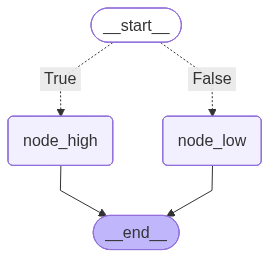

In [13]:
from typing import TypedDict
from langchain_core.runnables import RunnableConfig
from langgraph.constants import START, END
from langgraph.graph import StateGraph


# ======================================================
# 1. 定义 State（状态）
# ======================================================
class State(TypedDict):
    score: int


# ======================================================
# 2. 定义两个节点：node_high / node_low
# ======================================================
def node_high(state: State, config: RunnableConfig):
    # node_high 执行后 score + 100（高分加成）
    return {"score": state["score"] + 100}

def node_low(state: State, config: RunnableConfig):
    # node_low 执行后 score + 5（低分加成）
    return {"score": state["score"] + 5}


# ======================================================
# 3. 创建 Graph
# ======================================================
builder = StateGraph(State)

builder.add_node("node_high", node_high)
builder.add_node("node_low", node_low)


# ======================================================
# 4. 定义 routing_func（返回布尔值）
# ------------------------------------------------------
# 注意：返回 True / False，而不是节点名
# 由 mapping 映射到具体节点
# ======================================================
def routing_func(state: State) -> bool:
    if state["score"] > 50:
        return True     # True → node_high
    else:
        return False    # False → node_low


# ======================================================
# 5. 添加条件边（虚线）
# ------------------------------------------------------
# mapping 的作用：
#   True  -> node_high
#   False -> node_low
#
# 这样 START 会画 2 条虚线条件边
# ======================================================
builder.add_conditional_edges(
    START,
    routing_func,
    {
        True: "node_high",
        False: "node_low"
    }
)


# ======================================================
# 6. 添加 node → END 的普通边
# ======================================================
builder.add_edge("node_high", END)
builder.add_edge("node_low", END)


# ======================================================
# 7. 编译图
# ======================================================
graph = builder.compile()


# ======================================================
# 8. 运行示例
# ======================================================
print("输入 score=30 → 路由到 node_low:")
print(graph.invoke({"score": 30}))   # → node_low → END

print("\n输入 score=80 → 路由到 node_high:")
print(graph.invoke({"score": 80}))  # → node_high → END


# ======================================================
# 9. 可视化（会看到两条条件虚线）
# ======================================================
from IPython.display import Image, display
display(Image(graph.get_graph(xray=False).draw_mermaid_png()))

# 案例二：Send 动态分发（并行处理）

{'items': ['苹果', '香蕉', '橙子', '葡萄', '苹果 ✓', '香蕉 ✓', '橙子 ✓', '葡萄 ✓']}


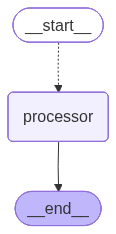

In [14]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph
from langgraph.types import Send
from langgraph.constants import START, END
from operator import add  # 用于 Annotated(list, add) 自动追加


# ======================================================
# 1. 定义 State（全局共享状态）
# ------------------------------------------------------
# items: 自动累加的字符串列表
#   Annotated[List[str], add] 用于：
#     - 当节点返回 {"items": [...]} 时
#     - 会把新元素 append 到 state["items"] 里
# ======================================================
class State(TypedDict):
    items: Annotated[List[str], add]


# ======================================================
# 2. PrivateState（节点内部使用的局部状态）
# ------------------------------------------------------
# Send("processor", {"item": ...}) 时，会将 {"item": "..."} 作为
# processor 的局部 state（不是 StateGraph 的全局 state）
# ======================================================
class PrivateState(TypedDict):
    item: str


# ======================================================
# 3. 节点 processor
# ------------------------------------------------------
# 收到 item（来自 PrivateState），然后把 item+" 已处理" 放入 items
# ======================================================
def processor(state: PrivateState) -> State:
    res = state["item"] + " ✓"
    return {"items": [res]}   # 会 append 到全局 items


# ======================================================
# 4. 创建 StateGraph 并注册节点
# ======================================================
builder = StateGraph(State)
builder.add_node("processor", processor)


# ======================================================
# 5. routing_func：根据 items 生成多个 Send 指令
# ------------------------------------------------------
# START → routing_func
# routing_func 根据 state["items"] 中的每条 item
# 构造 Send("processor", {"item": item})
# 最终形成一个 list[Send,...]
#
# LangGraph 收到多条 Send，会并行触发多个 processor 执行
# ======================================================
def routing_func(state: State):
    result = []
    for item in state["items"]:
        # 将每条 item 作为 PrivateState 发送给 processor
        result.append(Send("processor", {"item": item}))
    return result


# ======================================================
# 6. 将 START 的条件边接到 routing_func
# ------------------------------------------------------
# routing_func 返回的 Send 列表会决定要执行哪些节点
# ======================================================
builder.add_conditional_edges(START, routing_func, ["processor"])

# processor 处理完毕后结束
builder.add_edge("processor", END)


# ======================================================
# 7. 编译图
# ======================================================
graph = builder.compile()


# ======================================================
# 8. 测试：输入多个 item
# ------------------------------------------------------
# 初始 state：
#   items = ["苹果", "香蕉", "橙子", "葡萄"]
#
# routing_func 会对每个元素发出一个 Send("processor", {"item": item})
# processor 会把 item+" ✓" append 到 items 中
#
# ======================================================
result = graph.invoke({"items": ["苹果", "香蕉", "橙子", "葡萄"]})
print(result)

# ======================================================
# 9. 可视化（会看到条件虚线）
# ======================================================
from IPython.display import Image, display
display(Image(graph.get_graph(xray=False).draw_mermaid_png()))

# 案例三：Command API（命令式控制流）

{'tasks': ['学习Python', '写代码', '测试程序', '部署上线', '学习Python [完成]', '写代码 [完成]', '测试程序 [完成]', '部署上线 [完成]']}


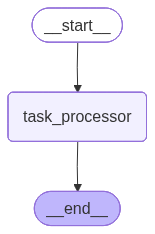

In [15]:
from operator import add
from typing import TypedDict, Annotated

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import Command


# ======================================================
# 1. 定义 State（全局共享状态）
# ------------------------------------------------------
# tasks: 一个字符串列表
# Annotated[list[str], add]
#   意味着：当某个节点返回 {"tasks": [...]} 时，
#   LangGraph 会自行执行 append（增量累加），
#   而不是覆盖列表。
# ======================================================
class State(TypedDict):
    tasks: Annotated[list[str], add]


# ======================================================
# 2. 定义节点 task_processor
# ------------------------------------------------------
# 本例展示 LangGraph 的 Command API：
#
#   return Command(
#       goto="xxx",
#       update={"tasks": ...}
#   )
#
# Command 的作用是：
#   - update：更新 State
#   - goto：显式指定下一个节点（忽略边的自动路由）
#
# ======================================================
def task_processor(state: State):
    completed_tasks = []

    # 遍历 state 中已有的 tasks
    for task in state["tasks"]:
        # 每条 task 后加 " [完成]"
        completed_tasks.append(task + " [完成]")

    # 返回 Command 类型（而不是 State dict）
    # Command 允许：
    #   - 更新 State
    #   - 指定要跳到哪个 Node
    return Command(
        goto=END,                  # 下一步直接跳到 END（手动控制流向）
        update={"tasks": completed_tasks}  # 更新字段（会 append 到 State.tasks）
    )


# ======================================================
# 3. 创建 StateGraph，并注册节点
# ------------------------------------------------------
# StateGraph(State) 绑定状态结构
# builder.add_node("task_processor", task_processor) 注册节点
#
# 注意：由于 task_processor 内部 return Command(... goto=END)
#       所以下面 add_edge 不需要写 task_processor → END
#       因为 goto 已经覆盖掉默认边
# ======================================================
builder = StateGraph(State)

builder.add_node("task_processor", task_processor)

# START → task_processor
builder.add_edge(START, "task_processor")


# ======================================================
# 4. 编译图
# ======================================================
graph = builder.compile()


# ======================================================
# 5. 测试运行
# ------------------------------------------------------
# 输入 tasks 列表：
#   ["学习Python", "写代码", "测试程序", "部署上线"]
#
# task_processor 会把每条变成：
#   "学习Python [完成]"  "写代码 [完成]"  等
#
# 然后用 Command 指定 goto=END，所以流程结束。
# ======================================================
print(
    graph.invoke(
        {"tasks": ["学习Python", "写代码", "测试程序", "部署上线"]}
    )
)

# 可视化图结构
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 输出示例：
# {
#   'tasks': ['学习Python', '写代码', '测试程序', '部署上线',
#             '学习Python [完成]', '写代码 [完成]', '测试程序 [完成]', '部署上线 [完成]']
# }

# 案例四：Command 循环控制（goto + 条件判断）

In [16]:
from operator import add
from typing import TypedDict, Annotated

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import Command


# ======================================================
# 1. 定义 State（全局共享状态）
# ------------------------------------------------------
# logs: 一个字符串列表，记录流程日志
# step: 当前步骤编号
# ======================================================
class State(TypedDict):
    logs: Annotated[list[str], add]
    step: int


# ======================================================
# 2. 定义节点 step_one
# ------------------------------------------------------
# 使用 Command 的 goto 参数，动态决定下一步走哪个节点
# ======================================================
def step_one(state: State):
    return Command(
        goto="step_two",  # 显式指定下一步去 step_two
        update={
            "logs": ["步骤一：初始化完成"],
            "step": 1
        }
    )


def step_two(state: State):
    current_step = state["step"]
    
    # 根据条件决定下一步
    if current_step < 3:
        next_node = "step_two"  # 循环回自己
    else:
        next_node = END  # 结束
    
    return Command(
        goto=next_node,
        update={
            "logs": [f"步骤二：处理中... (第{current_step + 1}次)"],
            "step": current_step + 1
        }
    )


# ======================================================
# 3. 创建 StateGraph，并注册节点
# ======================================================
builder = StateGraph(State)

builder.add_node("step_one", step_one)
builder.add_node("step_two", step_two)

# START → step_one
builder.add_edge(START, "step_one")
# 注意：不需要添加 step_one → step_two 的边
# 因为 Command(goto=...) 会覆盖默认边


# ======================================================
# 4. 编译图
# ======================================================
graph = builder.compile()


# ======================================================
# 5. 测试运行
# ------------------------------------------------------
# step_one 会设置 step=1，然后跳到 step_two
# step_two 会循环执行直到 step >= 3
# ======================================================
result = graph.invoke({"logs": ["流程启动"], "step": 0})
print("最终结果：")
print(result)

print("\n执行日志：")
for log in result["logs"]:
    print(f"  - {log}")

# 可视化图结构
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

最终结果：
{'logs': ['流程启动', '步骤一：初始化完成', '步骤二：处理中... (第2次)', '步骤二：处理中... (第3次)', '步骤二：处理中... (第4次)'], 'step': 4}

执行日志：
  - 流程启动
  - 步骤一：初始化完成
  - 步骤二：处理中... (第2次)
  - 步骤二：处理中... (第3次)
  - 步骤二：处理中... (第4次)


ValueError: Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 204.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

# 案例五：Subgraph 子图嵌套

In [ ]:
from operator import add
from typing import TypedDict, Annotated

from langgraph.constants import END, START
from langgraph.graph import StateGraph, MessagesState


# ======================================================
# 1. 定义全局 State（父图与子图都使用相同的 State）
# ------------------------------------------------------
# logs: 自动累加的字符串列表
# Annotated[list[str], add] 会让 logs 自动 append，
# 而不是覆盖整个列表。
# ======================================================
class State(TypedDict):
    logs: Annotated[list[str], add]


# ======================================================
# 2. 定义子图节点（sub_processor）
# ------------------------------------------------------
# 输入：State
# 输出：包含更新的 State
#
# 子图负责处理某个子任务
# ======================================================
def sub_processor(state: State) -> dict:
    return {"logs": ["[子图] 数据处理完成"]}


# ======================================================
# 3. 构建子图（SubGraph）
# ------------------------------------------------------
# subgraph_builder = StateGraph(State)
# 子图与父图使用相同的 State 类型
# ======================================================
subgraph_builder = StateGraph(State)

# 注册子图节点
subgraph_builder.add_node("sub_processor", sub_processor)

# 子图流向：START → sub_processor → END
subgraph_builder.add_edge(START, "sub_processor")
subgraph_builder.add_edge("sub_processor", END)

# 编译子图，得到可调用的 subgraph
subgraph = subgraph_builder.compile()


# ======================================================
# 4. 构建父图（Parent Graph）
# ------------------------------------------------------
# 父图包含一个节点 subgraph_node，这个节点本质上是：
#   在父图里"调用整个 subgraph"
#
# subgraph_node 没有自己的处理函数，
# 直接使用 subgraph 当作一个节点。
# ======================================================
builder = StateGraph(State)

# subgraph 作为一个 node 使用
builder.add_node("subgraph_node", subgraph)

# 父图流向：START → subgraph_node → END
builder.add_edge(START, "subgraph_node")
builder.add_edge("subgraph_node", END)

# 编译父图
graph = builder.compile()


# ======================================================
# 5. 测试运行父图
# ------------------------------------------------------
# 初始状态：
#   {"logs": ["[父图] 开始执行"]}
#
# 父图执行：
#   START → subgraph_node（= 调用 subgraph）
#
# 子图执行：
#   START → sub_processor → END
#   sub_processor 返回 {"logs": ["[子图] 数据处理完成"]},
#   被 append 到 State.logs
# ======================================================
result = graph.invoke({"logs": ["[父图] 开始执行"]})
print("最终结果：")
print(result)

print("\n执行日志：")
for log in result["logs"]:
    print(f"  - {log}")

# 可视化图结构
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

最终结果：
{'logs': ['[父图] 开始执行', '[父图] 开始执行', '[子图] 数据处理完成']}

执行日志：
  - [父图] 开始执行
  - [父图] 开始执行
  - [子图] 数据处理完成
